<a href="https://colab.research.google.com/github/Grupo-14-SOA/tp3_hpc/blob/main/Cuaderno_1_miercoles_grupo14_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 INTRODUCCION

Este ejercicio toma una imagen pasada por un parametro y un angulo de rotacion y aplica transformaciones lineales para rotar la imgen.

1° Se aplica una traslacion para llevar los puntos de la imagen al entro de coordenadas y asi poder rotar la imagen sobre su centro.

2° Se aplica una transformacion lineal a la imagen para rotarla.

3° Se aplica la inversa de la primera traslacion para volver a poner la imagen en su lugar.

La formula abreviada de la composision de las tres transformaciones mencionadas es la siguiente.

$Φ = Angulo$

$  α = cos(Φ) $

$  β = sin(Φ) $

$   x´ = (α*(x-centro_x) - β *(y-centro_y) + centro_x) $

$   y´ = (α*(y-centro_y) + β*(x-centro_x) + centro_y) $


# 2 ARMADO DE AMBIENTE

Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

In [ ]:
#@title ## 2.1 Especifique la imagen
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ### Especifique el angulo de rotacion en grados:
import numpy
try:
  angulo_de_rotacion = 80#@param {type:"number"}
  angulo_de_rotacion_en_radianes = numpy.radians(angulo_de_rotacion)
except:
  print("Ingrese un angulo valido")

!wget {url_imagen} -O imagen.jpg

#Seteamos la lista para guardar los tiempos de ejecucion concurrentes
tiempos_de_ejecucion_concurrente = []

--2021-11-24 17:50:40--  https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg [following]
--2021-11-24 17:50:40--  https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg [following]
--2021-11-24 17:50:40--  https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147032 (144K) [image/j

In [ ]:
#@title ## 2.2 Instala en el cuaderno el módulo CUDA de Python.

!pip install pycuda

     |████████████████████████████████| 1.7 MB 3.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 66 kB 4.8 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627661 sha256=bf5ffa6f6b664a1369937a9fcd406c36eed7bf33323d16238012b111e208fc67
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=75a47d581353c1eb90739ac4d67270c32d4d2668fbb46dc09f2ef717ddb051ec
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


#  3 DESARROLLO


## 3.1 Codigo de CPU

Imagen del filtro: imagen.jpg -- [768, 1024]
Tiempo de conversión de imagen: 3744.824 [ms]
Tiempo Total: 3867.3 [ms]


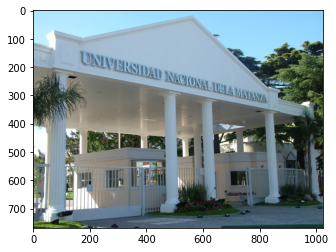

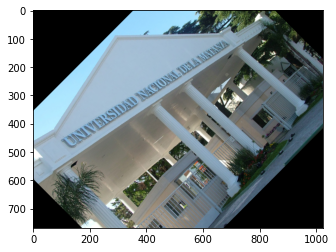

In [ ]:
 %matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------
try:
  # Calculamos el Alfa de la transformacion
  alfa = numpy.cos(angulo_de_rotacion_en_radianes)

  # Calculamos el Alfa de la transformacion
  beta = numpy.sin(angulo_de_rotacion_en_radianes)

  # Obtengo la imagen sobre la que voy a trabajar
  img_nombre = 'imagen.jpg'
  img = plt.imread(img_nombre)
  # Obtengo las proporsiones de la imagen. 
  a,l,r = img.shape
  centro_y = l//2
  centro_x = a//2

  # Convierto la imagen al tipo de dato Int32.
  img_pic_cpu = img
  img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

  # Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
  img_N = numpy.empty((a,l,3), dtype=numpy.int32())

  tiempo_img = datetime.now()
  for i in range(0, img_N.shape[0]):
    for j in range(0, img_N.shape[1]):
      i_out = (alfa*(i-centro_x) + beta*(j-centro_y) + centro_x)
      j_out = (alfa*(j-centro_y) - beta*(i-centro_x) + centro_y)
      i_o=numpy.int(i_out)
      j_o=numpy.int(j_out)
      if a>i_o >0 and l>j_o >0:
        pixel_data=img[i_o,j_o,:]
      else:
        pixel_data = [0,0,0]  
      img_N[i, j, :] = pixel_data

  tiempo_img_secuencial = datetime.now() - tiempo_img
  # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
  print("Imagen del filtro: " + img_nombre + " -" + "- [" + str(a) + ", " + str(l) + "]" )  

  plt.figure()
  imgplot=plt.imshow( img_pic_cpu )

  plt.figure()
  imgplot = plt.imshow( img_N )

  tiempo_total_secuencial = datetime.now() - tiempo_total

  print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img_secuencial   ), "[ms]" )
  print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total_secuencial ), "[ms]" )
except e:
  print("A ocurrido un error durante la ejecucion, por favor verifique haber ejecutado los pasos previos")

## 3.2 Codigo de GPU

Imagen del filtro: imagen.jpg -RGB- [1024, 768]
Thread: [ 6 , 6  ], Bloque : [ 171 , 128 ]
Total de Thread: [ 1026 , 768  ]  =  787968
Tiempo TOTAL:  84.465 [ms]
Tiempo GPU  :  0.105 [ms]


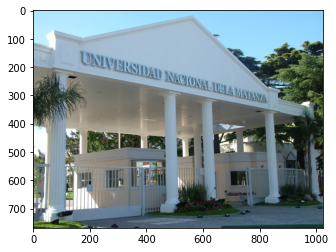

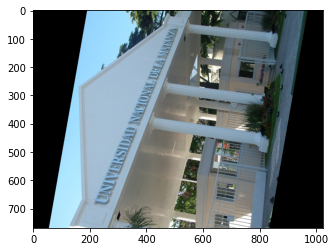

In [ ]:
%matplotlib inline
try:
  from datetime import datetime
  tiempo_total = datetime.now()

  import matplotlib.pyplot as plt
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule

  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
  # --------------------------------------------

  #@markdown ---
  cantidad_hilos_GPU =  6#@param {type:"slider",min:1,max:32,step:1}
  procesamiento_imagenes = "imagen_completa" #@param ["mitad_izquierda", "mitad_derecha", "imagen_completa"]
  #@markdown ---

  # Calculamos el Alfa de la transformacion
  alfa = numpy.cos(angulo_de_rotacion_en_radianes)

  # Calculamos el Alfa de la transformacion
  beta = numpy.sin(angulo_de_rotacion_en_radianes)

  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre ) 
    
  # summarize some details about the image 
  img_ancho, img_alto  = image.size 

  # Convierto la imagen comprimida en JPEG/PNG a array
  img_O_cpu = numpy.asarray(image)
  img_O_cpu = img_O_cpu.astype( numpy.int32() )
  img_R_cpu = numpy.empty_like( img_O_cpu)
  img_R_cpu[::] = 0

  # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
  img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )
  img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )

  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod( img_O_gpu, img_O_cpu )
  cuda.memcpy_htod( img_R_gpu, img_R_cpu )

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img( int mitad, int ancho, int alto, int *img_O, int *img_R, float angulo)
  {
    float alfa = cos(angulo);
    float beta = sin(angulo);
    int r =0;
    int v =0;
    int a =0;

    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    int centro_x = ancho/2;
    int centro_y = alto/2;
    if((mitad == 1 && idx < ancho/2 && idy < alto) || (mitad == 2 && idy < alto && idx >= ancho/2 && idx < ancho))
    {
        int xr = (int)(alfa*(idx-centro_x) - beta*(idy-centro_y) + centro_x);
        int yr = (int)(alfa*(idy-centro_y) + beta*(idx-centro_x) + centro_y);

        if(0<= xr && xr < ancho && 0 <= yr && yr < alto){
          r = img_O[(xr+(yr*ancho))*3]; 
          v = img_O[((xr+(yr*ancho))*3)+1]; 
          a = img_O[((xr+(yr*ancho))*3)+2];
        }
        else{
          r=0;
          v=0;
          a=0;
        }
        
        img_R[(idx+(idy*ancho))*3] = r;
        img_R[((idx+(idy*ancho))*3)+1] = v;
        img_R[((idx+(idy*ancho))*3)+2] = a;

    }else if(idx < ancho && idy < alto){
      if(mitad==0){
        int xr = (int)(alfa*(idx-centro_x) - beta*(idy-centro_y) + centro_x);
        int yr = (int)(alfa*(idy-centro_y) + beta*(idx-centro_x) + centro_y);
        
        if(0<= xr && xr< ancho && 0 < yr && yr < alto){
            r = img_O[(xr+(yr*ancho))*3]; 
            v = img_O[((xr+(yr*ancho))*3)+1]; 
            a = img_O[((xr+(yr*ancho))*3)+2];
          }
          else{

              r = 0;
            v = 0 ;
            a = 0 ;
          }
        img_R[(idx+(idy*ancho))*3] = r;
        img_R[((idx+(idy*ancho))*3)+1] = v;
        img_R[((idx+(idy*ancho))*3)+2] = a;
      }
      else{
        img_R[(idx+(idy*ancho))*3] = img_O[(idx+(idy*ancho))*3];
        img_R[(idx+(idy*ancho))*3 + 1] = img_O[(idx+(idy*ancho))*3 + 1];
        img_R[(idx+(idy*ancho))*3 + 2] = img_O[(idx+(idy*ancho))*3 + 2];
      }
        
        
    }
  }
  """) 

  # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
  print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_img")

  tiempo_img = datetime.now()

  dim_hilo_x = cantidad_hilos_GPU
  dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = cantidad_hilos_GPU
  dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

  print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

  tiempo_img = datetime.now()

  mitad = 0
  if procesamiento_imagenes == 'mitad_izquierda':
    mitad = 1
  elif procesamiento_imagenes == 'mitad_derecha':
    mitad = 2

  kernel( numpy.int32( mitad), numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu,numpy.float32(angulo_de_rotacion_en_radianes), block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

  tiempo_img = datetime.now() - tiempo_img

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

  # Muestro la imagen Original el filtro.
  plt.figure()
  imgplot=plt.imshow( img_O_cpu )

  # Muestro la imagen luego de aplicarle el filtro.
  plt.figure()
  imgplot=plt.imshow( img_R_cpu )

  tiempo_total = datetime.now() - tiempo_total

  print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
  print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

  tiempos_de_ejecucion_concurrente.append((cantidad_hilos_GPU, tiempo_img))
except ModuleNotFoundError:
  print("A ocurrido un error al querer importar uno de los modulos, por favor verifique haber ejecutado los pasos previos")
except:
  print("A ocurrido un error durante la ejecucion, por favor verifique haber ejecutado los pasos previos")

#4 Tabla de pasos

## 4.1 pasos para codigo CPU


Procesador |	Funciòn       |	Detalle
-----------|----------------|--------
CPU | @param | Lectura de los parametros, imagen_url_imagen y angulo_de_rotacion, ingresados por el usuario
CPU |wget url_imagen	|  Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU |pip install pycuda | Instala en el cuaderno los driver de CUDA para Python.
CPU |	matplotlib inline |	Macro de Colab para mostrar imagenes.
CPU |	import |	Importa los módulos para funcionar.
CPU |	datetime.now() |	Toma el tiempo actual.
CPU | numpy.cos() | Se calcula el coseno el angulo ingresado y se almacena en la variable alfa
CPU | numpy.sin() | Se calcula el coseno el angulo ingresado y se almacena en la variable beta
CPU	| plt.imread() |	Abre el archivo de la imagen y la lee como un array.
CPU | img.shape | Obtenemos las dimenciones de la imagen
CPU | img_pic_cpu.astype(numpy.int32())| Se define el tipo de dato como Int32
CPU |	numpy.empty() |	Genera el array destino, que tendrá a la imagen resultado con las dimenciones de la imagen de origen.
CPU	|print() | Informa los atributos de la imagen.
CPU	|plt.imshow |	Muestra la imagen original.
CPU	|plt.imshow |	Muestra la imagen resultado.
CPU | print() | Muestra los tiempos de ejecucion



## 4.2 Pasos para codigo GPU

Procesador |	Funciòn       |	Detalle
-----------|----------------|--------
CPU | @param | Lectura de los parametros, imagen_url_imagen, angulo_de_rotacion, cantidad_de_hilos y procesamiento_imagenes, ingresados por el usuario
CPU |wget url_imagen	|  Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU |pip install pycuda | Instala en el cuaderno los driver de CUDA para Python.
CPU |	matplotlib inline |	Macro de Colab para mostrar imagenes.
CPU |	import |	Importa los módulos para funcionar.
CPU |	datetime.now() |	Toma el tiempo actual.
CPU	| Image.open() |	Abre el archivo de la imagen.
CPU |	numpy.asarray(imagen) |	Convierte el formato de la imagen a un array.
CPU | img_pic_cpu.astype()| Se define el tipo de dato como Int32
CPU |	numpy.empty_like() |	Genera el array destino, que tendrá a la imagen resultado. con las dimenciones de la imagen de origen.
CPU | img_R_cpu[::] = 0 | Se carga la imagen de destino con todos los pixeles en negro
**GPU**	| cuda.mem_alloc() |	Reserva la memoria para las imagenes en GPU.
**GPU**	| cuda.memcpy_htod() |	Copio los valores en crudo de las imagenes al GPU.
CPU	|print() | Informa los atributos de la imagen.
CPU	| SourceModule() |	Posee el còdigo del kernel.
CPU	| module.get_function() |	convierte el texto del kernel en funcion de Python.
CPU	| dim_hilo_x, dim_hilo_y |	Calcula las dimensiones para la ejecuciòn de 2D.
**GPU** |	kernel() |	Ejecuta el kernel en GPU, enviando los parametros.
CPU	| cuda.memcpy_dtoh() |	Copia desde la memoria GPU al CPU.
CPU	|plt.imshow |	Muestra la imagen original.
CPU	|plt.imshow |	Muestra la imagen resultado.
CPU | print() | Muestra los tiempos de ejecucion


# 5 Metricas

En esta sección vamos a analizar, mediante gráficos y resultados, las diferencias entre la implementación secuencial y concurrente. Ademas vamos a incluir gráficos comparando los tiempos de respuesta con la cantidad de nucleos GPU implementados

Tiempo de procesamiento en ejecucion secuencial en milisegundos:  3744.824
Ahora una comparativa de los tiempos de ejecucion concurrentes y la cantidad de hilos asociados
Tiempo de ejecucion concurrente en milisegundos 0.198 | Cantidad de hilos 1
Tiempo de ejecucion concurrente en milisegundos 0.105 | Cantidad de hilos 2
Tiempo de ejecucion concurrente en milisegundos 0.165 | Cantidad de hilos 4
Tiempo de ejecucion concurrente en milisegundos 0.108 | Cantidad de hilos 10
Tiempo de ejecucion concurrente en milisegundos 0.139 | Cantidad de hilos 13
Tiempo de ejecucion concurrente en milisegundos 0.098 | Cantidad de hilos 17
Tiempo de ejecucion concurrente en milisegundos 0.089 | Cantidad de hilos 18
Tiempo de ejecucion concurrente en milisegundos 0.128 | Cantidad de hilos 19
Tiempo de ejecucion concurrente en milisegundos 0.112 | Cantidad de hilos 20
Tiempo de ejecucion concurrente en milisegundos 0.12 | Cantidad de hilos 21
Tiempo de ejecucion concurrente en milisegundos 0.107 | Cantida

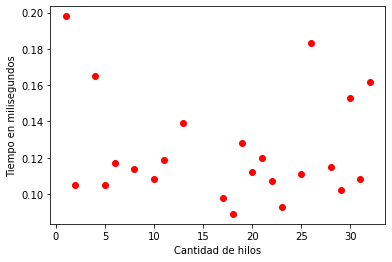

In [ ]:
#@title 5.1 Análisis con código

plt.xlabel("Cantidad de hilos")
plt.ylabel("Tiempo en milisegundos")

print("Tiempo de procesamiento en ejecucion secuencial en milisegundos: ", tiempo_en_ms(tiempo_img_secuencial))

print("Ahora una comparativa de los tiempos de ejecucion concurrentes y la cantidad de hilos asociados")
for n in tiempos_de_ejecucion_concurrente:
  print("Tiempo de ejecucion concurrente en milisegundos", tiempo_en_ms(n[1]) ,"| Cantidad de hilos", n[0])
  plt.scatter(n[0],tiempo_en_ms(n[1]), color='r')
print("GRÁFICO ASOCIADO")
plt.show()

# 6 Bibliografia

[1] https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326

[2] https://revistas.tec.ac.cr/index.php/matematica/article/view/5340

[3] https://www.matem.unam.mx/~rgomez/geometria/Capitulo3.pdf

[4] https://facundoq.github.io/courses/aa2018/res/04_imagenes_numpy.html